# CNN Polyp Classification

Team 13: James Medel, Sparsha Ramakrishna, Shreya Hunur, Jay Bharadva, Priyank Jagad

May 12, 2022

In [1]:
import tensorflow_addons as tfa
import tensorflow as tf
from tensorflow import keras 
from tensorflow.keras.models import load_model
from keras.metrics import Precision, Recall
from tensorflow_addons.metrics import F1Score
from keras import datasets, layers, models, metrics, backend as K
import h5py
from tensorflow.keras import __version__ as keras_version
from tensorflow.keras import datasets, layers, models
from tensorflow.keras.models import Sequential, Model
from tensorflow.keras.layers import Input, Flatten, Dense, Activation, Lambda, Cropping2D, Dropout, BatchNormalization
from tensorflow.keras.layers import Conv2D
from tensorflow.keras.layers import GlobalMaxPooling2D

In [2]:
import os
import csv
import cv2
import sys
import glob
import random
import collections
import pandas as pd
import itertools
import numpy as np
import seaborn as sns
from tqdm import tqdm

from pathlib import Path
import matplotlib.pyplot as plt
import matplotlib.image as mpimg

from sklearn.metrics import confusion_matrix, classification_report
from sklearn.preprocessing import LabelEncoder, LabelBinarizer
from sklearn import model_selection

import xml.etree.ElementTree as ET

In [3]:
def get_filepaths(basepath, remove_ext=False):
    files = []
    filenames = []
    for filename in os.listdir(basepath):
#         print("filename =", filename)
        if remove_ext is True:
            file_name, file_ext = filename.split(".")
#             print("file_name =", file_name)
#             print("file_ext =", file_ext)
            filepath = os.path.join(basepath, file_name)
            files.append(filepath)
            filenames.append(file_name)
        else:
            filepath = os.path.join(basepath, filename)
            files.append(filepath)
            filenames.append(filename)
    return files, filenames

In [4]:
def get_filepaths_videonum_dirs_xy(X_basepath, y_basepath):
    videonum_X_filepaths = []
    videonum_X_filenames = []
    videonum_y_filepaths = []
    videonum_y_filenames = []
    for videonum_X_dir, videonum_y_dir in zip(os.listdir(X_basepath), os.listdir(y_basepath)):
        videonum_X_dirpath = os.path.join(X_basepath, videonum_X_dir)
        videonum_y_dirpath = os.path.join(y_basepath, videonum_y_dir)
        videonum_y_dirfilepaths_tmp = []
        videonum_y_dirfilenames_tmp = []
        videonum_X_dirfilepaths, videonum_X_dirfilenames = get_filepaths(videonum_X_dirpath, remove_ext=True)
        videonum_y_dirfilepaths, videonum_y_dirfilenames = get_filepaths(videonum_y_dirpath, remove_ext=True)
#         print("len(videonum_X_dirfilenames) =", len(videonum_X_dirfilenames))
#         print("len(videonum_y_dirfilenames) =", len(videonum_y_dirfilenames))
        if len(videonum_X_dirfilenames) != len(videonum_y_dirfilenames):
            for y_i in range(len(videonum_y_dirfilenames)):
                if videonum_y_dirfilenames[y_i] in videonum_X_dirfilenames:
#                     print("videonum_y_dirfilenames[y_i] =", videonum_y_dirfilenames[y_i])
#                     print("is in videonum_X_dirfilenames = ", videonum_X_dirfilenames)
                    videonum_y_dirfilenames_tmp.append(videonum_y_dirfilenames[y_i] + ".xml")
                    videonum_y_dirfilepaths_tmp.append(videonum_y_dirfilepaths[y_i] + ".xml")
            videonum_y_filepaths.extend(videonum_y_dirfilepaths_tmp)
            videonum_y_filenames.extend(videonum_y_dirfilenames_tmp)
#             print("len(videonum_X_dirfilenames) =", len(videonum_X_dirfilenames))
#             print("len(videonum_y_dirfilenames_tmp) =", len(videonum_y_dirfilenames_tmp))
        else:
            videonum_y_dirfilepaths = [filepath + ".xml" for filepath in videonum_y_dirfilepaths]
            videonum_y_dirfilenames = [filename + ".xml" for filename in videonum_y_dirfilenames]
            videonum_y_filepaths.extend(videonum_y_dirfilepaths)
            videonum_y_filenames.extend(videonum_y_dirfilenames)
#             print("len(videonum_X_dirfilenames) =", len(videonum_X_dirfilenames))
#             print("len(videonum_y_dirfilenames) =", len(videonum_y_dirfilenames))
        videonum_X_dirfilepaths = [filepath + ".jpg" for filepath in videonum_X_dirfilepaths]
        videonum_X_dirfilenames = [filename + ".jpg" for filename in videonum_X_dirfilenames]
        videonum_X_filepaths.extend(videonum_X_dirfilepaths)
        videonum_X_filenames.extend(videonum_X_dirfilenames)
    return videonum_X_filepaths, videonum_X_filenames, videonum_y_filepaths, videonum_y_filenames

In [5]:
def read_img(img_path, flag = cv2.IMREAD_COLOR):
    # (height, width, 3)
    image = cv2.imread(img_path, flag)
    image = cv2.cvtColor(image, cv2.COLOR_BGR2RGB)
    return image


In [6]:
def get_xml_label_names(xml_files):
    label_names = []
    for xml_file in tqdm(xml_files):
        train_y_tree = ET.parse(xml_file)
        train_y_root = train_y_tree.getroot()
        if train_y_root.find("object") != None:
            train_y_object = train_y_root.find("object")
            train_y_polyp_name = train_y_object.find("name").text
        else:
            train_y_polyp_name = "Not Specified"
        label_names.append(train_y_polyp_name)
    return label_names

def get_xml_boundboxes(xml_files):
    bound_boxes = []
    for xml_file in tqdm(xml_files):
        train_y_tree = ET.parse(xml_file)
        train_y_root = train_y_tree.getroot()
        if train_y_root.find("object") != None:
            train_y_object = train_y_root.find("object")
            train_y_bndbox = train_y_object.find("bndbox")
            train_y_bndbox_xmin = train_y_bndbox.find("xmin").text
            train_y_bndbox_ymin = train_y_bndbox.find("ymin").text
            train_y_bndbox_xmax = train_y_bndbox.find("xmax").text
            train_y_bndbox_ymax = train_y_bndbox.find("ymax").text
            bound_box_tuple = (train_y_bndbox_xmin, train_y_bndbox_ymin, train_y_bndbox_xmax, train_y_bndbox_ymax)
        else:
            bound_box_tuple = False
        bound_boxes.append(
            bound_box_tuple
        )
    return bound_boxes

In [7]:
def resize_image(image, size):
    resized_image = cv2.resize(image, (size, size))
    return resize_image

def get_images(image_group, size, flag = cv2.IMREAD_COLOR):
    images = []
    for image_path in tqdm(image_group):
        image = read_img(image_path, flag)
        resized_img = cv2.resize(image, (size, size))
        images.append(resized_img)
    return images

def remove_non_labeled_polyps(img_filepaths, img_filenames, polyp_names):
    cln_X_img_filepaths = []
    cln_X_img_filenames = []
    cln_y_polyp_names = []
    for img_filepath, img_filename, label in zip(img_filepaths, img_filenames, polyp_names):
        if label != "Not Specified":
            cln_X_img_filepaths.append(img_filepath)
            cln_X_img_filenames.append(img_filename)
            cln_y_polyp_names.append(label)
            
    return cln_X_img_filepaths, cln_X_img_filenames, cln_y_polyp_names

In [8]:
def get_txt_label_names(txt_files):
    label_names = []
    for txt_file in tqdm(txt_files):
        file = open(txt_file, 'r+')
        polyp_name = file.readline()
        label_names.append(polyp_name)
        file.close()

    return label_names

In [9]:
# The following functions, I referenced from this stackoverflow:
# https://datascience.stackexchange.com/questions/45165/how-to-get-accuracy-f1-precision-and-recall-for-a-keras-model
def recall(y_true, y_pred):
    print("recall: calculating true_positives")
    true_positives = K.sum(K.round(K.clip(y_true * y_pred, 0, 1)))
    print("calculating possible_positives")
    possible_positives = K.sum(K.round(K.clip(y_true, 0, 1)))
    recall = true_positives / (possible_positives + K.epsilon())
    return recall

def precision(y_true, y_pred):
    print("precision: calculating true_positives")
    true_positives = K.sum(K.round(K.clip(y_true * y_pred, 0, 1)))
    print("calculating predicted_positives")
    predicted_positives = K.sum(K.round(K.clip(y_pred, 0, 1)))
    precision = true_positives / (predicted_positives + K.epsilon())
    return precision

def f1_score(y_true, y_pred):
    print("f1_score: calculating recall")
    recall_m = recall(y_true, y_pred)
    precision_m = precision(y_true, y_pred)
    f1_score_m = 2*((recall_m*precision_m)/(recall_m+precision_m+K.epsilon()))
    return f1_score_m

In [59]:
def plot_sample(X, y, y_pred, index, src_title="Polyp Classification", save_img=True, save_dst=None):
    plt.figure(figsize = (4,4))
    plt.title(src_title, fontsize=20)
    plt.imshow(X[index])
#     plt.xlabel("Actual: {}\nPred: {}".format(
#         classes[y[index]], classes[y_pred[index]]),
#         fontsize=16)
    height = X[index].shape[0]
    width = X[index].shape[1]
    plt.text(width/10, height + 8.5,
        "Actual: {}\nPred: {}".format(
        classes[y[index]], classes[y_pred[index]]),
        va='top',
        fontsize=16)
    plt.axis("off")
    
    if save_img is True:
        if save_dst is not None:
            if not os.path.exists(save_dst):
                os.makedirs(save_dst)
            plt.savefig("{}/pred_polyp_{}_{}.jpg".format(
                save_dst, classes[y_pred[index]], index
            ), bbox_inches="tight")
        else:
            print("Not saving image; no save dst")

In [ ]:
# google colab specific
# %cd ..

In [ ]:
# !ls

In [ ]:
# drive.mount('content/gdrive')

In [ ]:
# !ln -s /content/gdrive/My\ Drive/ /mydrive

In [ ]:
# !ls /mydrive

In [ ]:
# !ls /mydrive/PolypsSet/

In [ ]:
train_y_basepath = "PolypsSet/train2019/Annotation"
file_type = ".xml"
train_y_filepaths, train_y_filenames = get_filepaths(train_y_basepath, file_type)

In [ ]:
train_X_basepath = "PolypsSet/train2019/Image"
file_type = ".jpg"
train_X_filepaths, train_X_filenames = get_filepaths(train_X_basepath, file_type)

In [ ]:
train_y_polyp_names = get_xml_label_names(train_y_filepaths[:7000])

In [ ]:

cln_train_X_filepaths, cln_train_X_filenames, cln_train_y_polyp_names = remove_non_labeled_polyps(
    train_X_filepaths[:7000], train_X_filenames[:7000], train_y_polyp_names)

In [ ]:
train_X_images = get_images(cln_train_X_filepaths, 192)

In [ ]:
# ignore for now since we'll do this on augmented data
# X_train = np.array(train_X_images)
# X_train = X_train / 255
# label_enc = LabelEncoder()
# train_y = label_enc.fit_transform(cln_train_y_polyp_names)
# classes = ['adenomatous', 'hyperplastic']

In [ ]:
import albumentations as A

In [ ]:
# augment 14,000 images out of the sample of 6586 images
images_to_generate = 14000

In [ ]:
img_augmented_path="PolypsSet/train2019/aug_img_192_clf/"
label_augmented_path="PolypsSet/train2019/aug_label_192_clf/" # path to gray seg masks

In [ ]:
aug = A.Compose([
    A.VerticalFlip(p=0.5),
    A.RandomRotate90(p=0.5),
    A.HorizontalFlip(p=1),
    A.Transpose(p=1),
    A.GridDistortion(p=1)
])

In [ ]:
i=1
# augmenting on top of 100 images and 100 masked images gen 2000
# then save them in a folder
while i <= images_to_generate:
    number = random.randint(0, len(train_X_images[:100])-1)
    orig_image = train_X_images[number]
    orig_label = cln_train_y_polyp_names[number]
    
    augmented = aug(image = orig_image)
    transformed_image = augmented["image"]
    transformed_label = orig_label
    
    # due to opencv being bgr, so go rgb
    transformed_image = cv2.cvtColor(transformed_image, cv2.COLOR_BGR2RGB)
    
    new_image_path = "%s/aug_image_%s.jpg" %(img_augmented_path, i)
    new_label_path = "%s/aug_label_%s.txt" %(label_augmented_path, i)
    
    plt.imsave(new_image_path, transformed_image)
    file = open(new_label_path, "w")
    file.write(transformed_label)
    file.close()
    i = i+1


## Load Augmented Polyp Training Set

In [14]:
aug_train_X_basepath = "PolypsSet/train2019/aug_img_192_clf"
file_type = ".jpg"
aug_train_X_filepaths, aug_train_X_filenames = get_filepaths(aug_train_X_basepath, file_type)

In [15]:
aug_train_X_images = get_images(aug_train_X_filepaths, 192)

100%|███████████████████████████████████████████████████████████████████████████| 14000/14000 [00:16<00:00, 845.37it/s]


In [16]:
aug_X_train = np.array(aug_train_X_images)

In [17]:
aug_X_train = aug_X_train / 255

In [18]:
aug_train_label_basepath = "PolypsSet/train2019/aug_label_192_clf"
file_type = ".txt"
aug_train_label_filepaths, aug_train_label_filenames = get_filepaths(aug_train_label_basepath)

In [19]:
aug_y_train = get_txt_label_names(aug_train_label_filepaths)

100%|██████████████████████████████████████████████████████████████████████████| 14000/14000 [00:10<00:00, 1301.42it/s]


In [20]:
label_enc = LabelEncoder()
train_y = label_enc.fit_transform(aug_y_train)
classes = ['adenomatous', 'hyperplastic']

In [21]:
# Not able to allocate storage
X_train_polyp, X_test_polyp, y_train_polyp, y_test_polyp = model_selection.train_test_split(
    aug_X_train, train_y, test_size=0.2, random_state=42
)

In [18]:
cnn = models.Sequential([
    # 2 Convolution layers: first with 32 filters, second with 64 filters
    layers.Conv2D(filters=32, kernel_size=(3,3), activation="relu", input_shape=(192,192,3)),
    layers.MaxPooling2D((2,2)),
    
    layers.Conv2D(filters=64, kernel_size=(3,3), activation="relu"),
    layers.MaxPooling2D((2,2)),
    
    # 2 Dense layers
    layers.Flatten(),
    layers.Dense(64, activation="relu"),
    layers.Dense(1, activation="sigmoid")
])

In [19]:
# F1Score num_classes based on binary classification, so 1
cnn.compile(optimizer="adam",
            loss="binary_crossentropy",
            metrics=["accuracy", Precision(), Recall(), F1Score(num_classes=1)])

In [20]:
history = cnn.fit(X_train_polyp, y_train_polyp, validation_split=0.2, epochs=5)

Epoch 1/5
280/280 [==============================] - 73s 133ms/step - loss: 0.6216 - accuracy: 0.6715 - precision: 0.6306 - recall: 0.4612 - f1_score: 0.5774 - val_loss: 0.5001 - val_accuracy: 0.7558 - val_precision: 0.7522 - val_recall: 0.6271 - val_f1_score: 0.5930
Epoch 2/5
280/280 [==============================] - 9s 33ms/step - loss: 0.4484 - accuracy: 0.7767 - precision: 0.7249 - recall: 0.7251 - f1_score: 0.5776 - val_loss: 0.4692 - val_accuracy: 0.7621 - val_precision: 0.6521 - val_recall: 0.9333 - val_f1_score: 0.5930
Epoch 3/5
280/280 [==============================] - 9s 33ms/step - loss: 0.3057 - accuracy: 0.8673 - precision: 0.8337 - recall: 0.8408 - f1_score: 0.5776 - val_loss: 0.3566 - val_accuracy: 0.8446 - val_precision: 0.8625 - val_recall: 0.7511 - val_f1_score: 0.5930
Epoch 4/5
280/280 [==============================] - 9s 33ms/step - loss: 0.1783 - accuracy: 0.9316 - precision: 0.9131 - recall: 0.9189 - f1_score: 0.5776 - val_loss: 0.2591 - val_accuracy: 0.8960 - 

## Plot Train vs Valid Loss Curves After Training CNN Classifier

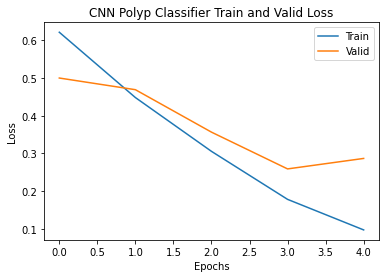

In [21]:
plt.figure()
plt.plot(history.history["loss"])
plt.plot(history.history["val_loss"])
plt.title("CNN Polyp Classifier Train and Valid Loss")
plt.xlabel("Epochs")
plt.ylabel("Loss")
plt.legend(["Train", "Valid"], loc="upper right")
plt.show()

## Plot Train vs Valid Accuracy Curves After Training CNN Classifier

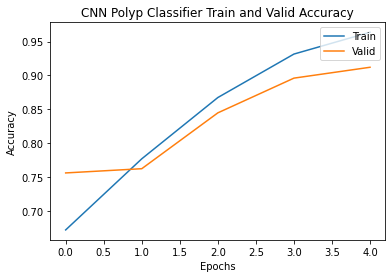

In [22]:
plt.figure()
plt.plot(history.history["accuracy"])
plt.plot(history.history["val_accuracy"])
plt.title("CNN Polyp Classifier Train and Valid Accuracy")
plt.xlabel("Epochs")
plt.ylabel("Accuracy")
plt.legend(["Train", "Valid"], loc="upper right")
plt.show()

## Plot Train vs Valid Precision Curves After Training CNN Classifier

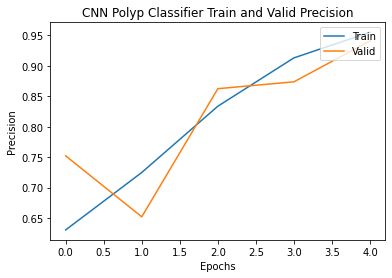

In [24]:
plt.figure()
plt.plot(history.history["precision"])
plt.plot(history.history["val_precision"])
plt.title("CNN Polyp Classifier Train and Valid Precision")
plt.xlabel("Epochs")
plt.ylabel("Precision")
plt.legend(["Train", "Valid"], loc="upper right")
plt.show()

## Plot Train vs Valid Recall Curves After Training CNN Classifier

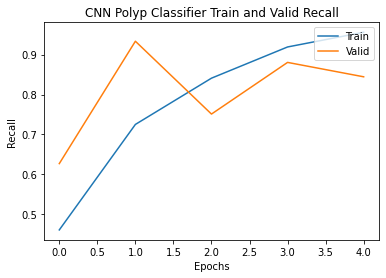

In [25]:
plt.figure()
plt.plot(history.history["recall"])
plt.plot(history.history["val_recall"])
plt.title("CNN Polyp Classifier Train and Valid Recall")
plt.xlabel("Epochs")
plt.ylabel("Recall")
plt.legend(["Train", "Valid"], loc="upper right")
plt.show()

## Plot Train vs Valid F1 Score Curves After Training CNN Classifier

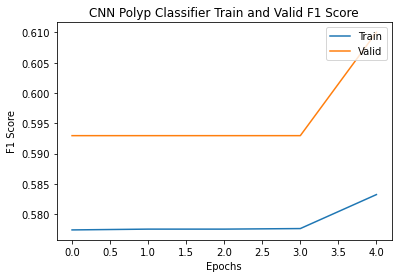

In [26]:
plt.figure()
plt.plot(history.history["f1_score"])
plt.plot(history.history["val_f1_score"])
plt.title("CNN Polyp Classifier Train and Valid F1 Score")
plt.xlabel("Epochs")
plt.ylabel("F1 Score")
plt.legend(["Train", "Valid"], loc="upper right")
plt.show()

## Evaluate CNN on Testing Set

In [27]:
# took 2000 and tested model on that
cnn_eval = cnn.evaluate(X_test_polyp[:2000], y_test_polyp[:2000])

63/63 [==============================] - 1s 15ms/step - loss: 0.2941 - accuracy: 0.9005 - precision: 0.9356 - recall: 0.8136 - f1_score: 0.5973


In [28]:
cnn.save('polyp_cnn_clf_14000.h5')

## Run Predictions

In [22]:
classes = ['adenomatous', 'hyperplastic']

In [23]:
cnn = load_model("polyp_cnn_clf_14000.h5")

In [25]:
y_pred = cnn.predict(X_test_polyp)

In [26]:
y_pred[:5]

array([[2.7068684e-04],
       [1.0395596e-03],
       [2.3507287e-03],
       [5.9105682e-01],
       [3.6132140e-03]], dtype=float32)

In [27]:
y_pred_classes = [np.argmax(element) for element in y_pred]

In [28]:
print("Classification Report: \n", classification_report(y_test_polyp, y_pred_classes))

Classification Report: 
               precision    recall  f1-score   support

           0       0.60      1.00      0.75      1678
           1       0.00      0.00      0.00      1122

    accuracy                           0.60      2800
   macro avg       0.30      0.50      0.37      2800
weighted avg       0.36      0.60      0.45      2800



C:\Users\james\miniconda3\envs\yolov4-gpu\lib\site-packages\sklearn\metrics\_classification.py:1248: UndefinedMetricWarning: Precision and F-score are ill-defined and being set to 0.0 in labels with no predicted samples. Use `zero_division` parameter to control this behavior.
  _warn_prf(average, modifier, msg_start, len(result))
C:\Users\james\miniconda3\envs\yolov4-gpu\lib\site-packages\sklearn\metrics\_classification.py:1248: UndefinedMetricWarning: Precision and F-score are ill-defined and being set to 0.0 in labels with no predicted samples. Use `zero_division` parameter to control this behavior.
  _warn_prf(average, modifier, msg_start, len(result))
C:\Users\james\miniconda3\envs\yolov4-gpu\lib\site-packages\sklearn\metrics\_classification.py:1248: UndefinedMetricWarning: Precision and F-score are ill-defined and being set to 0.0 in labels with no predicted samples. Use `zero_division` parameter to control this behavior.
  _warn_prf(average, modifier, msg_start, len(result))


In [29]:
y_pred_classes[:5]

[0, 0, 0, 0, 0]

In [30]:
y_test_polyp[:5]

array([0, 0, 1, 0, 0], dtype=int64)

Plot the **Actual Polyp Image** being at index 0. Then also show the predicted value just below it. We'll see the **actual label** vs the **predicted label**.

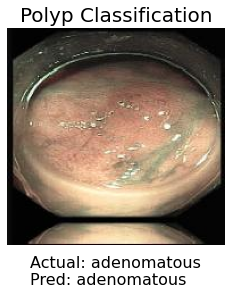

In [60]:
plot_sample(X_test_polyp, 
            y_test_polyp, y_pred_classes, index=0, 
            src_title="Polyp Classification",
            save_img=True,
            save_dst="cnn_clf/trained_14000_aug/clf_pred_images")

From running our Polyp classifier above, we can see it correctly classified the polyp to be **adenomatous**.